COPYRIGHT NOTICE
In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.


this is an experimental model intended to elucidate possible mechanics for attention across sequences in addition to tokenwise. it is reasonably fast and efficient. conceptually, the design was envisioned by me and coded through refinement with OpenAI Codex Orion One and chatgpt. i find that if i cant understand a thing, however clever it is- its wrong.
so, this is largely a from-scratch along aligned principles. 

you are advised in life to apply a similar practice. nothing good comes of shit you dont comprehend.

"hierarchical multi-scale transformer with MoE-like  selection"

my own fucking activation function

my own fucking loss method borrowing from harmonic loss but using student-t distribution!
https://arxiv.org/abs/2502.01628

XOR from  Two-argument activation functions learn soft XOR operations like cortical neurons
https://arxiv.org/abs/2110.06871note that my implementation is a differential XOR for backprop capability
motivation: little bit of internal reasoning maybe? Impact: slows down convergence somewhat
ROPE from google

entropy based reward to encourage diverse attention
https://arxiv.org/abs/2203.0919

https://arxiv.org/pdf/2502.05171
latent reasoning in a discrete and hopefully efficient form2


WOLF optimizer experimental by me, it may not beat adam but it is simpler than adam, closer to SGD with some smoothing of integration
impact: speeds up convergence somewhat for early iterations and will not NAN from high LR.
probable benefit- switch optimizers after model drops. could be good for bigger models.. maybe

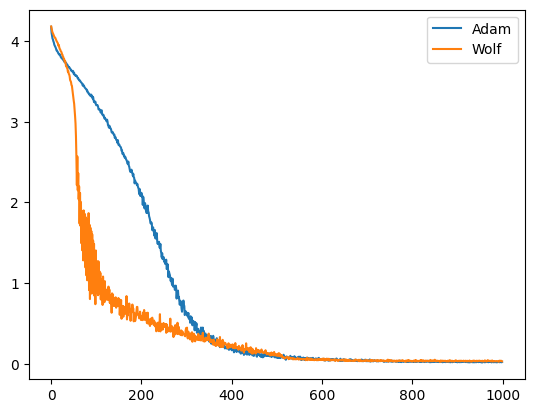
m 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests

In [3]:

def student_t_unembedding(hidden_states, unembedding, df=2.718281828459, eps=1e-9):
    """
    Student's t-based unembedding with optional placeholder modification.
    
    Arguments:
      hidden_states: (B, S, D)  => model’s output embeddings (hidden state)
      unembedding:   (D, V)    => learnable "word vectors" (unembedding matrix)
      df (float): degrees of freedom for the Student's t distribution
      eps (float): numerical epsilon to avoid log(0) and div-by-zero
          corresponding to the placeholder token. The distances for that token will be adjusted 
          using an adaptive noise factor.
    
    Returns:
      p: (B, S, V)  probability distribution over V vocabulary tokens.
    """
    B, S, D = hidden_states.shape
    V = unembedding.shape[1]
    # Expand hidden => (B, S, 1, D)
    x_expanded = hidden_states.unsqueeze(2)
    # Expand unembedding => (1, 1, V, D)
    w_expanded = unembedding.t().unsqueeze(0).unsqueeze(0)  # shape: (1, 1, V, D)
    
    # Compute squared Euclidean distance between each hidden vector and each unembedding vector.
    dist_sq = torch.sum((x_expanded - w_expanded) ** 2, dim=-1).clamp(min=1e-6)  # (B, S, V)
        
    # Compute the negative energy:
    #    E = 0.5*(df + D) * log(1 + dist_sq / df)
    # and so log probability (up to an additive constant) is:
    #    log_p = -E
    log_p_unnorm = -0.5 * (df + D) * torch.log1p(dist_sq / df)  # (B, S, V)
    
    # Normalize via log_softmax over the vocabulary dimension.
    log_p = F.log_softmax(log_p_unnorm, dim=-1)  # (B, S, V)
    return log_p



class Wolf(Optimizer):
    """Implements Wolf algorithm."""
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8):
        # Define default parameters
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        # Initialize the parent Optimizer class first
        super().__init__(params, defaults)
        # Constants specific to Wolf
        # Initialize state for each parameter
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)  # Second moment estimate


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # Constant used in update rule
        et = 1 - etcerta
    
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
    
        # Iterate over parameter groups.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]
                exp_avg = state['p']
    
                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta
    
                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
    
                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)
    
                # AMP Compatibility: Ensure a step counter is updated
                state['step'] = state.get('step', 0) + 1  # Track optimization steps
    
        return loss

# ---------------------------------------------------
# Custom Activation
# ---------------------------------------------------
class ReferenceActivation(nn.Module):
    def __init__(self, gamma=24):
        super().__init__()
        self.gamma = gamma

    def forward(self, x):
        x.clamp_(-2, 2)
        log_x = torch.sign(x) * torch.log1p(torch.abs(x))
        safe_x = torch.nan_to_num(log_x, nan=0.0)

        return log_x / torch.sqrt(1 + self.gamma * log_x ** 2)
            
class CachedMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0, batch_first=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        # We use the built-in multihead attention module.
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=batch_first)
    
    def forward(self, query, key, value, past_kv=None):
        """
        query: (B, S_new, D)
        key, value: (B, S_current, D) for the current input tokens.
        past_kv: Tuple (past_key, past_value) or None.
        """
        if not self.training:
            if past_kv is not None:
                past_key, past_value = past_kv
                # Concatenate along the sequence dimension
                key = torch.cat([past_key, key], dim=1)
                value = torch.cat([past_value, value], dim=1)
            # Run the attention module.
            attn_output, _ = self.attn(query, key, value)
            # The new cache holds all keys and values computed so far.
            new_kv = (key, value)
            return attn_output, new_kv
        else:
            attn_output,attn_weights = self.attn(query, key, value)
            attn_weights.clamp_( min=1e-9, max=1.0)
            entropy = -torch.sum(attn_weights * torch.log(attn_weights + 1e-9), dim=-1)
            attn_weights_1 = attn_weights.sum(dim=-1)
            attn_weights_2 = attn_weights.sum(dim=-2)
            attn_weights = (attn_weights_1 + attn_weights_2)/2


            return attn_output, entropy, attn_weights
            
class RectifiedKAN(nn.Module):
    def __init__(self, embed_dim, expansion_factor=8, dropout=0.0):
        super().__init__()
        hidden_dim = expansion_factor * embed_dim

        self.expand = nn.Linear(embed_dim, hidden_dim)   
        self.activation = ReferenceActivation()
        self.linear = nn.Linear(hidden_dim, embed_dim,bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Now the first gemm already includes the shift
        x = self.expand(x)
        x = self.activation(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x



class TapeHeadBlock(nn.Module):
    def __init__(self, seq_len, embed_dim, vocab_size, num_heads=1, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.max_seq_len = seq_len
        self.vocab_size = vocab_size

        # Sinusoidal positional embeddings (Precomputed)
        self.register_buffer("pos_emb", self._build_sinusoidal_embedding(seq_len, embed_dim))

        # Rotary embedding setup
        self.use_rope = True  # Set to False to disable RoPE
        if self.use_rope:
            self.register_buffer("rope_freqs", self._build_rope_frequencies(embed_dim))

        # Attention layers
        self.cached_attn = CachedMultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln_attn = nn.LayerNorm(embed_dim)

        # MLP and normalization
        self.mlp = RectifiedKAN(embed_dim)
        self.ln_mlp = nn.LayerNorm(embed_dim)

        # Unembedding matrix

        # Logits cross-attention

    def _build_sinusoidal_embedding(self, seq_len, embed_dim):
        """Compute sinusoidal positional embeddings"""
        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        pos_emb = torch.zeros(seq_len, embed_dim)
        pos_emb[:, 0::2] = torch.sin(position * div_term)
        pos_emb[:, 1::2] = torch.cos(position * div_term)
        return pos_emb.unsqueeze(0)  # Shape: (1, seq_len, embed_dim)


    def _build_rope_frequencies(self, embed_dim):
        """Build the inverse frequency tensor for RoPE and ensure it is a PyTorch tensor."""
        half_dim = embed_dim // 2  # For D=256, half_dim = 128
        base_freqs = 1.0 / (10000 ** (torch.arange(0, half_dim, dtype=torch.float32) / half_dim))
        # Remove the repeat_interleave so we keep shape (half_dim,)
        return base_freqs

        
    def apply_rope(self,tensor, rope_freqs):
            """
            Apply Rotary Positional Embedding (RoPE) to the input tensor.
            
            Args:
                tensor (Tensor): Input tensor of shape (B, S, D), where
                                 B = batch size, S = sequence length, D = embedding dim.
                rope_freqs (Tensor): Frequency tensor of shape (D/2,) computed via _build_rope_frequencies.
                
            Returns:
                Tensor: The input tensor after applying RoPE, with the same shape (B, S, D).
                
            Detailed Steps & Dimensions:
              1. Let B, S, D = tensor.shape and half_dim = D//2.
              2. Compute positions: a tensor of shape (S,).
              3. Compute theta = positions.unsqueeze(1) * rope_freqs.unsqueeze(0)
                 -> theta has shape (S, half_dim).
              4. Compute sin_theta and cos_theta from theta, each of shape (S, half_dim),
                 then expand to (B, S, half_dim).
              5. Split tensor into two halves along the last dimension:
                 - x1 = tensor[..., 0::2] and x2 = tensor[..., 1::2], each with shape (B, S, half_dim).
                 (Alternatively, one can do: x1, x2 = torch.chunk(tensor, 2, dim=-1))
              6. Apply RoPE:
                 - x1_rot = x1 * cos_theta - x2 * sin_theta
                 - x2_rot = x1 * sin_theta + x2 * cos_theta
              7. Reassemble the output by interleaving x1_rot and x2_rot.
            """
            B, S, D = tensor.shape
            if S == 1:
                return tensor
            assert D % 2 == 0, "Embedding dimension must be even for RoPE."
            half_dim = D // 2  # e.g. for D=256, half_dim = 128
        
            # Ensure rope_freqs is on the same device and dtype as tensor.
            rope_freqs = rope_freqs.to(tensor.dtype)  # shape: (half_dim,)
        
            # 1. Compute positions (0, 1, ..., S-1): shape (S,)
            positions = torch.arange(S, device=tensor.device, dtype=tensor.dtype)
            
            # 2. Compute theta = positions * rope_freqs:
            #    positions: (S, 1), rope_freqs: (1, half_dim) --> theta: (S, half_dim)
            theta = positions.unsqueeze(1) * rope_freqs.unsqueeze(0)  # shape: (S, half_dim)
            
            # 3. Compute sin and cos of theta:
            sin_theta = theta.sin()  # shape: (S, half_dim)
            cos_theta = theta.cos()  # shape: (S, half_dim)
            
            # 4. Expand sin and cos to shape (B, S, half_dim)
            sin_theta = sin_theta.unsqueeze(0).expand(B, S, half_dim)
            cos_theta = cos_theta.unsqueeze(0).expand(B, S, half_dim)
            
            # 5. Split tensor into two halves (real and imaginary parts).
            # Here we use alternate slicing: the even-indexed dims are x1, odd-indexed are x2.
            x1 = tensor[..., 0::2]  # shape: (B, S, half_dim)
            x2 = tensor[..., 1::2]  # shape: (B, S, half_dim)
            
            # 6. Apply the RoPE rotation:
            x1_rot = x1 * cos_theta - x2 * sin_theta  # shape: (B, S, half_dim)
            x2_rot = x1 * sin_theta + x2 * cos_theta  # shape: (B, S, half_dim)
            
            # 7. Interleave x1_rot and x2_rot back together.
            # One approach is to create an empty tensor and then fill in even and odd indices.
            out = torch.empty_like(tensor)
            out[..., 0::2] = x1_rot
            out[..., 1::2] = x2_rot
        
            return out


    def forward(self, token_emb, prev_h, prev_emb, past_kv=None):
        """
        x: (B, S) input token IDs
        prev_h: (B, S, D) previous hidden state
        prev_emb: (B, S, D) previous embeddings
        logits: (B, S, V) logits distribution from previous block (can be None)
        past_kv: Dictionary with keys 'chunk_attn' and 'logits_attn' holding KV caches
        """

        past_chunk = past_kv.get('chunk_attn') if past_kv is not None else None
        # Compute token embeddings and add sinusoidal positional embeddings
        seq_len = token_emb.shape[1]  # Dynamically get sequence length
        layer_emb = token_emb + self.pos_emb[:, :seq_len, :]

        # Apply RoPE if enabled
        if self.use_rope:
            layer_emb = self.apply_rope(layer_emb, self.rope_freqs)

        # Attention input
        if prev_h is not None:
            attn_input = torch.cat([prev_emb, layer_emb, prev_h[:, -seq_len:, :]], dim=1)
            attn_input = attn_input[:, -seq_len:, :]

        else:
            attn_input = layer_emb


        # Compute Self-Attention with KV Caching
        if not self.training:
            if past_chunk is not None:
                attn_out, new_chunk_cache  = self.cached_attn(
                    attn_input, attn_input, attn_input, past_kv=past_chunk
                )
            else:
                attn_out, new_chunk_cache = self.cached_attn(attn_input, attn_input, attn_input)
        else:
            attn_out, entropy_chunk, attn_weights = self.cached_attn(attn_input, attn_input, attn_input)

        h_attn = self.ln_attn(attn_input + attn_out)

        
        # Pass through MLP
        h_mlp = self.ln_mlp(h_attn + self.mlp(h_attn))

        # Compute final logits
        # Return KV cache
        if not self.training:
            new_cache = {'chunk_attn': new_chunk_cache}
            return h_mlp, layer_emb, new_cache

        if self.training:
            attn_weights = torch.softmax(attn_weights, dim=-1)
            return h_mlp, layer_emb, entropy_chunk, attn_weights

class CharRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.activation = ReferenceActivation()

    def forward(self, x, h_prev):
        h_candidate = self.i2h(x) + self.h2h(h_prev)
        h_new = self.activation(h_candidate)
        return h_new

class CharRNNModel(nn.Module):
    def __init__(self, seq_len, vocab_size, embed_dim=128, hidden_size=256, num_layers=2, placeholder_idx=None):
        super().__init__()
        self.activation = ReferenceActivation()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.placeholder_idx = placeholder_idx

        self.cells_right = nn.ModuleList([
            CharRNNCell(embed_dim if i == 0 else hidden_size, hidden_size) for i in range(num_layers)
        ])
        self.cells_left = nn.ModuleList([
            CharRNNCell(embed_dim if i == 0 else hidden_size, hidden_size) for i in range(num_layers)
        ])

    def forward(self, embedded_x, past_kv=None):
        batch_size = embedded_x.shape[0]
    
        # ✅ Ensure hidden_state has a consistent shape
        if not self.training and past_kv is not None:
            # Evaluation mode: read from past_kv (expecting 3D shape)
            hidden_state = [kv[:, -1, :] for kv in past_kv]  # Always valid if kv has 3 dims
        else:
            # Training mode or no past_kv: initialize hidden state
            hidden_state = [torch.zeros(batch_size, self.hidden_size, device=embedded_x.device)
                            for _ in range(self.num_layers)]
    
        outputs = []
        new_hidden_state = []
    
        for t in range(embedded_x.shape[1]):
            input_t = embedded_x[:, t, :]
            new_hidden = []
    
            for layer in range(self.num_layers):
                cell_left = self.cells_left[layer]
                cell_right = self.cells_right[layer]
                h_prev = hidden_state[layer]  # (batch_size, hidden_size)
    
                h_new_left = cell_left(input_t, h_prev)
                h_new_right = cell_right(input_t, h_prev)
    
                # Combine left and right outputs
                a = self.activation(h_new_left)
                b = self.activation(h_new_right)
                h_new = 0.5 * (a + b - 2 * a * b)
    
                new_hidden.append(h_new)
                input_t = h_new
    
            hidden_state = new_hidden
            outputs.append(input_t)
    
            # ✅ Consistently shape cached hidden states as (batch_size, 1, hidden_size)
            new_hidden_state = [h.unsqueeze(1) for h in hidden_state]  # No if-check needed
    
        outputs = torch.stack(outputs, dim=1)  # (batch_size, seq_len, hidden_size)
    
        # ✅ In training, return None for cache. In eval, return consistent 3D cache.
        return outputs, new_hidden_state if not self.training else None



           

class TapeHead(nn.Module):
    """
    A Transformer-like block with progressive chunk sizes.
    Each layer inside the TapeHead doubles the chunk size.
    """
    def __init__(self, seq_len, embed_dim, vocab_size, num_layers=3, dropout=0.1,discriminate=0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.discriminate=discriminate
        layer_weights = torch.linspace(0.3, 1.0, steps=self.num_layers)
        layer_weights /= layer_weights.sum()  # Normalize
        self.register_buffer("layer_weights", layer_weights)
        # Create progressively larger TapeHeadBlocks for the left and right streams.

        self.blocks_left= nn.ModuleList([
            TapeHeadBlock(
                seq_len=seq_len,
                embed_dim=embed_dim,
                vocab_size=vocab_size,
                num_heads=4,  #true for up to 512 embed dem
                dropout=dropout
            )
            for i in range(num_layers)
        ])

        self.blocks_right = nn.ModuleList([
            TapeHeadBlock(
                seq_len=seq_len,
                embed_dim=embed_dim,
                vocab_size=vocab_size,
                num_heads=4,  # Inversely scale heads
                dropout=dropout
            )
            for i in range(num_layers)
        ])

        self.activation = nn.Sigmoid()

    def forward(self, token_emb, prev_h, prev_emb, past_kv=None):
        """
        past_kv: dictionary with keys 'left' and 'right', each is a list of caches (one per block).
        """
        attn_weights = []
        entropy = []
    
        if not self.training:
            if past_kv is None:
                past_kv = {'left': [None] * self.num_layers, 'right': [None] * self.num_layers}
            prev_emb_left = prev_emb.clone() if prev_emb is not None else None
            prev_h_left = prev_h.clone() if prev_h is not None else None
    
            new_past_left = []
            new_past_right = []
    
            for i in range(self.num_layers):
                # Process left block with its cache.
                    h_out_left, prev_emb_left, cache_left = self.blocks_left[i](
                         token_emb,prev_h_left, prev_emb_left, past_kv=past_kv['left'][i]
                    )
                                    # Process right block with its cache.
                    h_out,  prev_emb, cache_right = self.blocks_right[i](
                        token_emb,prev_h, prev_emb, past_kv=past_kv['right'][i])
                
                    if self.discriminate==0:
                        
                        a = self.activation(h_out_left)
                        b = self.activation(h_out)
                        h_out = 0.5 * (a + b - 2 * a * b)
                        prev_h_left = h_out
                        prev_h = h_out
                    elif self.discriminate==1:
                        combined = torch.stack([h_out_left, h_out], dim=-1)  # Shape: (B, S, D, 2)
                        weights = torch.softmax(combined, dim=-1)  # Normalize contributions
                        h_out = (combined * weights).sum(dim=-1)  # Shape: (B, S, D)
                        prev_h_left = h_out
                        prev_h = h_out

                    else:
                        h_out= h_out_left+h_out
                        prev_h_left = h_out
                        prev_h = h_out
                        
                    new_past_left.append(cache_left)  # Store all layers' caches
                    new_past_right.append(cache_right)  # Store all layers' caches

            prev_emb = 0.5 * (prev_emb + prev_emb_left)
            new_cache = {'left': new_past_left, 'right': new_past_right}
            return h_out, prev_emb, new_cache  # ✅ Properly returning all layer caches
    
        else:  # Training mode
            prev_emb_left = prev_emb.clone() if prev_emb is not None else None
            prev_h_left = prev_h.clone() if prev_h is not None else None
    
            for i in range(self.num_layers):
                # Process left block
                    h_out_left, prev_emb_left, entropy_left, attn_weights_left = self.blocks_left[i](
                        token_emb, prev_h_left, prev_emb_left,
                    )
        
                    # Process right block
                    h_out, prev_emb, entropy_right, attn_weights_right = self.blocks_right[i](
                        token_emb, prev_h, prev_emb
                    )
                    if self.discriminate==0:
                        
                        a = self.activation(h_out_left)
                        b = self.activation(h_out)
                        h_out = 0.5 * (a + b - 2 * a * b)
                        prev_h_left = h_out
                        prev_h = h_out
                    elif self.discriminate==1:
                        combined = torch.stack([h_out_left, h_out], dim=-1)  # Shape: (B, S, D, 2)
                        weights = torch.softmax(combined, dim=-1)  # Normalize contributions
                        h_out = (combined * weights).sum(dim=-1)  # Shape: (B, S, D)
                        prev_h_left = h_out
                        prev_h = h_out

                    else:
                        h_out= h_out_left+h_out
                        prev_h_left = h_out
                        prev_h = h_out
                        
                    attn_weights.append((attn_weights_left + attn_weights_right) / 2.0)
                    entropy.append((entropy_left + entropy_right) / 2.0)
    

            prev_emb = 0.5 * (prev_emb + prev_emb_left)
            
            attn_weights = torch.stack(attn_weights, dim=0)
            attn_weights *= self.layer_weights.view(-1, 1, 1)
            attn_weights = attn_weights.sum(dim=0)
            entropy = torch.sum(torch.stack(entropy)) / self.num_layers
                
            return  h_out, prev_emb, entropy, attn_weights  # ✅ Returns all caches correctly


           

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return x / (x.norm(2, dim=-1, keepdim=True) + self.eps) * self.weight


import torch
import torch.nn as nn

class Merger(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        # linear that goes from 2*V -> out_dim
        self.proj = nn.Linear(in_dim*2, out_dim, bias=False)

    def forward(self, heads_2d):
        """
        heads_2d: shape (2, B, S, V)
        We'll reshape it to (B, S, 2*V), pass it into self.proj, and place it back into heads_2d[1].
        """
        # heads_2d[0] = sub-head #1 (B, S, V)
        # heads_2d[1] = sub-head #2 (B, S, V)
        # 1) reshape to (B, S, 2*V):
        B, S, V = heads_2d.shape[1], heads_2d.shape[2], heads_2d.shape[3]
        merged_view = heads_2d.view(-1, S, 2*V)  # shape (B, S, 2*V)

        # 2) run through the linear
        #    result will be shape (B, S, out_dim)
        merged_out = self.proj(merged_view)  # (B, S, out_dim)

        # 3) Optionally, store back in heads_2d[1] or somewhere else.
        #    If you want to in-place the second head, make sure you keep track of shapes.
        #    Here, let's just re-view merged_out as (B, S, out_dim) => (1, B, S, out_dim)
        #    and store it in heads_2d[1].
        out_dim = merged_out.shape[-1]
        # ensure we can place it into heads_2d[1] shape (B, S, V) if out_dim == V
        # or allocate a new dimension for it, depending on design.

        if out_dim == V:
            # then we can store in heads_2d[1] in place
            heads_2d[1].copy_(merged_out)
            return heads_2d[1]  # shape (B, S, V)
        else:
            # If out_dim != V, you'd store it in a separate buffer or return merged_out directly
            return merged_out  # shape (B, S, out_dim)



class TapeTransformer(nn.Module):
    """
    Full GPT-like model with:
      - Token + Position Embeddings
      - Multiple stacked TapeHeads
    """
    def __init__(self, vocab_size, seq_len=128, num_layers=4, embed_dim=128, num_heads=2, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.neurotic_embed = nn.Embedding(vocab_size, embed_dim)
        self.holistic_embed = nn.Embedding(vocab_size, embed_dim)
        self.prophet = CharRNNModel(seq_len,vocab_size,embed_dim = embed_dim, hidden_size=embed_dim*2)
        self.rnn_projection = nn.Linear(embed_dim*2, embed_dim)

        # LayerNorm immediately after embeddings.
        self.embed_ln = nn.LayerNorm(embed_dim)
        self.codahead =  TapeHead(
                seq_len=seq_len,
                embed_dim=embed_dim,
                vocab_size=vocab_size,
                num_layers=2,
                dropout=dropout,
                discriminate=0
            )
        # Create a list of TapeHeads.
        self.residualheads = nn.ModuleList([
            TapeHead(
                seq_len=seq_len,
                embed_dim=embed_dim,
                vocab_size=vocab_size,
                num_layers=4,
                dropout=dropout,
                discriminate=1

            )
            for _ in range(num_heads)
        ])
        self.merger = Merger(in_dim=embed_dim, out_dim=embed_dim)
        self.final_norm = RMSNorm(len(self.residualheads) * embed_dim)
        self.norm_gate = nn.Parameter(torch.tensor(0.5))  # for potential supervisory context
        self.activation = ReferenceActivation()
        # Final unembedding.
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))
        self.merge_projection = nn.Linear(2 * embed_dim, embed_dim, bias=False)
        self.merge_projection_final = nn.Linear(len(self.residualheads) * embed_dim, embed_dim, bias=False)

    def forward(self, x, past_kv=None):
        """
        x: (B, S) integer token IDs.
        past_kv: list of caches (one per tape head) or None.
        Returns:
          p_final: (B, S, V) probability distribution,
          new_past_kv: updated caches.
        """
        # Ensure batch dimension.
        x = x.unsqueeze(0) if x.ndim == 1 else x
        B, S = x.shape
        assert S <= self.seq_len, "Sequence too long."

        prev_h = None
        prev_emb = None
        new_past_heads = None
        attn_weights = None
        all_heads_h = []
        entropy = []
        residual_h = torch.zeros((self.num_heads, 2, B, S, self.embed_dim), device=x.device)

        if not self.training:
            new_past_heads = []
            if past_kv is None:
                past_kv = (
                    [{'left': [None] * self.codahead.num_layers, 'right': [None] * self.codahead.num_layers}] +
                    [[torch.zeros(batch_size, 1, self.prophet.hidden_size, device=x.device)  # ✅ Added time dim
                      for _ in range(self.prophet.num_layers)]] +
                    [{'left': [None] * head.num_layers, 'right': [None] * head.num_layers}
                     for head in self.residualheads]
                )

                


            consistency = self.holistic_embed(x)
            sincerity = self.neurotic_embed(x)
            ##coda
            coda_h, prev_emb, head_cache = self.codahead(consistency, prev_h, prev_emb, past_kv=past_kv[0])
            new_past_heads.append(head_cache)


            prophecy,head_cache = self.prophet.forward(consistency,past_kv[1])
            new_past_heads.append(head_cache)

            residual_h[:, 0] = coda_h
            
            for i, head in enumerate(self.residualheads):
                 residual_h[i, 1], _, head_cache = head(sincerity, coda_h, prev_emb, past_kv=past_kv[2+i])

            for i in range(self.num_heads):
                all_heads_h.append(self.merger(residual_h[i]))
                new_past_heads.append(head_cache)

            merged_h = torch.cat(all_heads_h, dim=-1)

            activated_h = self.activation(merged_h)  # (B, S, num_heads, embed_dim)
            # Element-wise product across critics (to detect overlaps)
            # Keep the shape [16, 128, 1024]
            prod_h = torch.prod(activated_h + 1e-6, dim=2, keepdim=True)  # [16, 128, 1]

            # Expand prod_h to match the 1024 dimension for the XOR-like suppression
            prod_h = prod_h.expand(-1, -1, activated_h.shape[-1])  # [16, 128, 1024]
            # XOR-like suppression
            xor_h = activated_h - (self.num_heads - 1) * prod_h  # [16, 128, 1024]
            xor_h = 0.5 * xor_h  # Normalize
            xor_h = self.final_norm(xor_h) #remove instability
            prev_h = self.merge_projection_final(xor_h)#nn.Linear(len(self.residualheads) * embed_dim, embed_dim, bias=False)


        else:        
            consistency = self.holistic_embed(x)
            sincerity = self.neurotic_embed(x)
            coda_h, prev_emb, entropy_head, attn_weights = self.codahead(consistency, prev_h, prev_emb)
            residual_h[:, 0] = coda_h
            entropy.append(entropy_head)

            prophecy,_= self.prophet.forward(consistency)

            prophecy_proj = self.rnn_projection(prophecy)

            for i, head in enumerate(self.residualheads):
                residual_h[i, 1], _, entropy_head, attn_weights_head = head(sincerity, coda_h,prophecy_proj)
                
            for i in range(self.num_heads):
                all_heads_h.append(self.merger(residual_h[i]))
                attn_weights = attn_weights + attn_weights_head
                entropy.append(entropy_head)

            merged_h = torch.cat(all_heads_h, dim=-1)
            activated_h = self.activation(merged_h)  # (B, S, num_heads, embed_dim)
            # Element-wise product across critics (to detect overlaps)
            # Keep the shape [16, 128, 1024]
            prod_h = torch.prod(activated_h + 1e-6, dim=2, keepdim=True)  # [16, 128, 1]

            # Expand prod_h to match the 1024 dimension for the XOR-like suppression
            prod_h = prod_h.expand(-1, -1, activated_h.shape[-1])  # [16, 128, 1024]
            # XOR-like suppression
            xor_h = activated_h - (self.num_heads - 1) * prod_h  # [16, 128, 1024]
            xor_h = 0.5 * xor_h  # Normalize
            xor_h = self.final_norm(xor_h) #remove instability
            prev_h = self.merge_projection_final(xor_h)#nn.Linear(len(self.residualheads) * embed_dim, embed_dim, bias=False)
            
            entropy.append(entropy_head)   
        
        
        if not self.training:
            p_final = student_t_unembedding(prev_h, self.unembedding, df=2.718281828459, eps=1e-9)
            return p_final, new_past_heads
        else:
            attn_weights /= self.num_heads
            p_final = student_t_unembedding(prev_h, self.unembedding, df=2.718281828459, eps=1e-9)
            return p_final, torch.sum(torch.stack(entropy))/self.num_heads+1, attn_weights

In [4]:
import gc,torch

gc.collect()
torch.cuda.empty_cache()

In [5]:
# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))


vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])

    return x, y

# ====================================================
# Training Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TapeTransformer(
    vocab_size=vocab_size,  # example
    seq_len=128,
    num_layers=4,
    embed_dim=256,
    num_heads=4,
    dropout=0 #cannot use dropout, tooo slow
)
#model = torch.compile(model)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)
scaler = torch.amp.GradScaler()

num_epochs = 100
batch_size = 16
eps = 1e-8


In [7]:
from torchinfo import summary

summary(model, input_size=(16, 128), dtypes=[torch.long])

Layer (type:depth-idx)                                       Output Shape              Param #
TapeTransformer                                              [16, 128, 65]             279,553
├─Embedding: 1-1                                             [16, 128, 256]            16,640
├─Embedding: 1-2                                             [16, 128, 256]            16,640
├─TapeHead: 1-3                                              [16, 128, 256]            --
│    └─ModuleList: 2-5                                       --                        (recursive)
│    │    └─TapeHeadBlock: 3-1                               [16, 128, 256]            1,314,816
│    └─ModuleList: 2-6                                       --                        (recursive)
│    │    └─TapeHeadBlock: 3-2                               [16, 128, 256]            1,314,816
│    └─Sigmoid: 2-3                                          [16, 128, 256]            --
│    └─Sigmoid: 2-4                               

In [126]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

49879553

In [127]:
import torch
import math
from collections import deque


# Training control variables
seq_len = 128  # Start with the smallest sequence
max_seq_len = 128
batch_size = 16


# Loss tracking
epochs_per_check = 10  # Print every 10 epochs
target_loss = max(math.log(vocab_size/(seq_len+1)),0)

In [128]:
# Adjusted Code to Improve EWMA Size and Implement Loss Ticker as a Moving Graph

import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

# --- Configuration Constants ---
CHAR_WIDTH = 8  # Font size 8 for token rendering
CHAR_HEIGHT = 11
SEQ_LEN = 128
BATCH_SIZE = 16
LOSS_BAR_HEIGHT = 32
EWMA_HEIGHT = 32  # Increased to accommodate large text (previously 32)

# Full-resolution framebuffer dimensions
container_width = CHAR_WIDTH * SEQ_LEN  # 1024 pixels
container_height = CHAR_HEIGHT * BATCH_SIZE  # 176 pixels
total_height = container_height + LOSS_BAR_HEIGHT + EWMA_HEIGHT  # Adjusted for larger EWMA

# Final scaled-down dimensions
scaled_width = container_width   # 512 pixels
scaled_height = total_height  # 170 pixels

# Initialize framebuffer
framebuffer = np.zeros((total_height, container_width, 3), dtype=np.uint8)

# EWMA storage
loss_history = []
ticker_history = np.zeros(SEQ_LEN, dtype=np.float32)  # Stock ticker moving buffer
loss_memory = 0.0
# Load font
try:
    font = ImageFont.truetype("DejaVuSansMono.ttf", 8)  # Monospaced font
    font_large = ImageFont.truetype("DejaVuSansMono.ttf", 64)  # Large EWMA display
except:
    font = ImageFont.load_default()
    font_large = font

# --- Color Mapping Functions ---
def get_flame_color(val):
    """Map a normalized value to a flame-like color."""
    return np.array([int(val * 255), int(val * 0.5 * 255), 0], dtype=np.uint8)

# --- IPython Display Setup ---
out = widgets.Output()
display(out)

def get_dynamic_color(attn_val, loss_val):
    """
    Compute a dynamic color transition between flame orange (uncertain) and phosphor green (confident).
    
    attn_val: Normalized attention value (0 to 1)
    loss_val: Normalized loss value (0 to 1, inverted as 1 - loss)
    
    Returns an RGB color as a NumPy array.
    colors late in training will often be red. this is suggested to swap out for get_flame_color
    but only on fine tuning on new data.
    """
    certainty = 1 - loss_val  # High certainty = low loss
    
    # Define RGB endpoints
    orange = np.array([attn_val * 255, attn_val * 0.5 * 255, 0], dtype=np.uint8)   # Uncertain (High Loss)
    green = np.array([attn_val * 0.5 * 255, attn_val * 255, attn_val * 0.25 * 255], dtype=np.uint8)  # Confident (Low Loss)
    
    # Interpolate based on certainty (0 = uncertain/orange, 1 = confident/green)
    color = (certainty * green) + ((1 - certainty) * orange)
    
    return color.astype(np.uint8)
# --- Framebuffer Update Function ---
def update_framebuffer(attn_weights, token_losses, current_loss, tokens,entropy):
    attn_weights =(attn_weights-attn_weights.min())/(np.ptp(attn_weights))
    token_losses =(token_losses-token_losses.min())/(np.ptp(token_losses))

    """Render the text grid with coloration based on attn * inverse loss."""
    global framebuffer, loss_history, ticker_history, loss_memory

    # Normalize to [0,1]

    # Create image buffer
    img = Image.new("RGB", (container_width, total_height), (0, 0, 0))
    draw = ImageDraw.Draw(img)

    # Render text with colored intensity
    char_positions = [
        (col * CHAR_WIDTH, row * CHAR_HEIGHT + EWMA_HEIGHT + LOSS_BAR_HEIGHT, tokens[row][col])
        for row in range(BATCH_SIZE) for col in range(SEQ_LEN)
    ]
    colors = [
        tuple(get_dynamic_color(attn_weights[row, col], attn_weights[row, col]))
        for row in range(BATCH_SIZE) for col in range(SEQ_LEN)
    ]
    for (x, y, char), color in zip(char_positions, colors):
        draw.text((x, y), char, font=font, fill=color)

                 
    etcerta = 0.367879441  # Constant used in update rule
    et = 1 - etcerta   
    update = loss_memory * et + np.minimum(12, np.maximum(current_loss , 0)) * etcerta
    loss_memory = loss_memory * et + update * etcerta
    # --- EWMA Display (LARGE FONT) ---
    loss_history.append(current_loss)
    if len(loss_history) > 128:
        loss_history.pop(0)
    ewma = loss_memory
    ewma_text = f"{ewma:.4f}"
    draw.text((container_width-128, 0), ewma_text, font_size=32, fill=(65,255, 125))
    ent_text = f"{entropy:.4f}"
    draw.text((10, 0), ent_text, font_size=32, fill=(255,125, 0))  

    # --- Moving Loss Ticker Graph ---
    ticker_history = np.roll(ticker_history, -1)  # Shift left
    ticker_history[-1] = current_loss  # Insert new loss on the right

    # Rescale ticker dynamically like a stock ticker (normalize to min-max range)
    min_loss = np.min(ticker_history)
    max_loss = np.max(ticker_history)
    range_loss = max_loss - min_loss if max_loss != min_loss else 1
    normalized_ticker = (ticker_history - min_loss) / range_loss

    # Draw ticker graph line
    # Optimized drawing loop (fewer function calls)
    y_vals = EWMA_HEIGHT + (1 - normalized_ticker) * LOSS_BAR_HEIGHT
    x_vals = np.arange(SEQ_LEN) * CHAR_WIDTH
    for i in range(SEQ_LEN - 1):
        draw.line([(x_vals[i], y_vals[i]), (x_vals[i + 1], y_vals[i + 1])], fill=(0, 255, 255), width=2)

    framebuffer = np.array(img)

# --- IPython Display Update Function ---
def update_display():
    """Show the framebuffer, scaled down by half using ipywidgets."""
    img = Image.fromarray(framebuffer)
    img_resized = img.resize((scaled_width, scaled_height), Image.LANCZOS)
    
    with out:
        clear_output(wait=True)
        display(img_resized)



Output()

In [ ]:
# Training loop for current sequence length
for epoch in range(100000):
    model.train()
    x_batch, targets = get_batch(batch_size, 128)
    x_batch_gpu, targets = x_batch.to(device), targets.to(device)
    optimizer.zero_grad()

    with torch.amp.autocast(device.type):
        preds, entropy, attn_weights = model(x_batch_gpu)
        # Decode token indices back to characters
        # Convert logits to log probabilities
        # Gather log probabilities of the correct tokens

        gathered_log_probs = torch.gather(preds, -1, targets.unsqueeze(-1)).squeeze(-1)
        # Compute per-token loss (neg log probs) and final loss
        weighted_loss = -gathered_log_probs  # Shape: (batch_size, seq_len)
        #pulled out of my ass:
        #multiply heads* seq * batch
        #coda + residual heads(3) + finalhead
        #if entropy is greater than this reward else punish
        test = 128*4*16/entropy
        final_loss = weighted_loss.mean()* test

        #multiply [qkv] * seq * batch and divide entropy by this
    
    scaler.scale(final_loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()
    loss_item = final_loss.item()
    
    loss_cpu = gathered_log_probs.cpu().detach().numpy()
    tokens = [[itos[idx] for idx in seq.tolist()] for seq in targets]
    attn_cpu = attn_weights.cpu().detach().numpy()

    update_framebuffer(attn_cpu, loss_cpu, loss_item, tokens,entropy.item())
    update_display()


    # Track loss & progress
    loss_val = loss_item
    loss_history.append(loss_val)

    # Update framebuffer visualization with real model outputs
    print(f"Epoch {epoch}, Loss: {loss_val:.6f}")




In [ ]:
torch.save(compiled_model, 'compiled_model.pth')
torch.save(model.state_dict(), 'model_weights.pth')


Generated Sample:
 Treasured Friends EkTETTTTtTTUkTTTUTTTTTPTTPTTPTTETkTETTEBuTTETTE BETTTTTtTTTTTETTTymTTkiTBTTEiTEETToiTTTTTVTTTTTTiWTTVTTTrTTTTTTTTTTtTTiATTTEETEPTTTATTPTiTTTTTTTTTTTTTTTWTTiTTTTTTATTTTBTGBTTTTMTTAkTEjTVTTTTATTTETTTPTEjCTTjTSTiATTTTjVTTkTECTTTTE VTTTETTTTWTTTTTTTETTiCTHTTkETT:TTS!TTTETUTtiTTTEATGETTTTTTTETTTTTTTTTTTtTTT&TTTTATTTiETTTTVTiTETEUTTTTiTTTATTPTTTTTTTTTTTTTTTTEiTTTEiTTTTTTTCTTT-TGXA
TPTTTTATTTTTCETETDETtPTTST TETUTATiTTTTTTTTTTTTTTETTATPTTTTTTEj
kGTETTTTTETCTiTTkTTTTiTPTTATTTTAkTTTTTETGiTTTTTTTAETTTT A


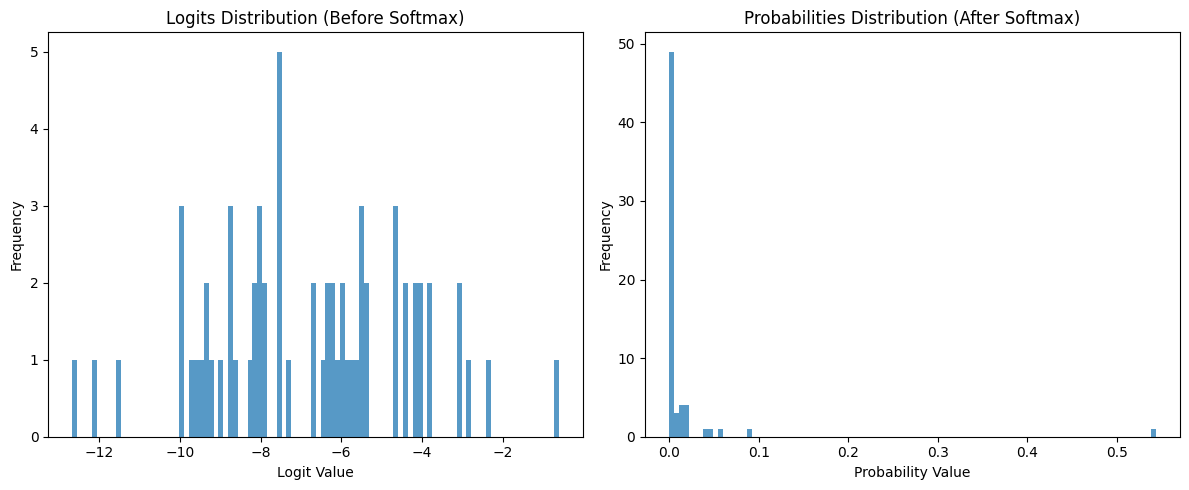

In [123]:
import matplotlib.pyplot as plt

logit_list = []  # Store raw logits
prob_list = []  # Store softmax probabilities

model.eval()
past_kv = None  # Initialize cache for the entire model.
with torch.no_grad():
    prompt = "Treasured Friends"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(500):  # Generate 200 tokens.
        inp = generated[:, -1:]  # Only use the last token.
        p, past_kv = model(inp, past_kv=past_kv)  # Forward pass with cache.
        last_token_logits = p[:, -1, :].cpu().numpy().flatten()  # Get raw logits
        logit_list.append(last_token_logits)

        temperature = 1.0 # Lower = more deterministic, Higher = more diverse (0.7–1.0 is good)
        last_token_probs = torch.softmax(p[:, -1, :] / temperature, dim=-1).cpu().numpy().flatten()
        prob_list.append(last_token_probs)

        predicted_token = torch.multinomial(torch.tensor(last_token_probs), num_samples=1).unsqueeze(0)  # Fix shape
        generated = torch.cat((generated, predicted_token.to(device)), dim=1)  # Concatenate properly

    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)

# Plot histograms of logits and probabilities
plt.figure(figsize=(12, 5))

# Plot logits histogram
plt.subplot(1, 2, 1)
plt.hist(logit_list[-1], bins=100, alpha=0.75)
plt.title("Logits Distribution (Before Softmax)")
plt.xlabel("Logit Value")
plt.ylabel("Frequency")

# Plot probabilities histogram
plt.subplot(1, 2, 2)
plt.hist(prob_list[-1], bins=100, alpha=0.75)
plt.title("Probabilities Distribution (After Softmax)")
plt.xlabel("Probability Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
logit_list = []  # Store raw logits
prob_list = []  # Store softmax probabilities

model.eval()
past_kv = None  # Initialize cache for the entire model.
with torch.no_grad():
    prompt = "Treasured Friends"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for step in range(200):  # Generate 500 tokens
        inp = generated[:, -1:]  # Only use the last token.
        
        # Print past_kv before forward pass
        # Forward pass with cache.
        p, past_kv = model(inp, past_kv=past_kv)  

        last_token_logits = p[:, -1, :].cpu().numpy().flatten()  # Get raw logits
        logit_list.append(last_token_logits)

        # Apply softmax with proper temperature scaling
        temperature = 1.0
        last_token_probs = torch.softmax(p[:, -1, :] / temperature, dim=-1).cpu().numpy().flatten()
        prob_list.append(last_token_probs)

        # Print probabilities (sanity check)
        if step % 50 == 0:
            print(f"Step {step} - Last token probs (min/max): {last_token_probs.min()} / {last_token_probs.max()}")

        # **Manually sample from multinomial distribution**
        predicted_token = torch.multinomial(torch.tensor(last_token_probs), num_samples=1).unsqueeze(0)  # Fix shape
        
        # Ensure the predicted token is within vocab range
        # Concatenate properly
        generated = torch.cat((generated, predicted_token.to(device)), dim=1)

    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)


In [ ]:
save_path = 'model_dict.pth'

# Save the model's state_dict
torch.save(model.state_dict(), save_path)


In [ ]:
save_path = 'model_dict.pth'

# Save the model's state_dict
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)


In [ ]:
optimizer = Wolf(model.parameters(), lr=0.3678)


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
from matplotlib import pyplot as plt

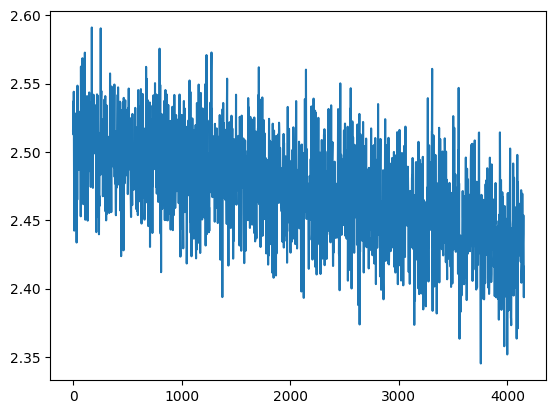

In [14]:
plt.plot(loss_history)